In [2]:
import pandas as pd
import os
import unicodedata
import re
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import classification_report, accuracy_score
import xgboost as xgb
from scipy.stats import uniform, randint
import mlflow
import numpy as np

In [3]:
def union_csv_files(folder_path, csv_files):
    df_list = []
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        print(f"Reading {file_path}")
        try:
            df = pd.read_csv(file_path, delimiter=',', on_bad_lines='skip')
            df_list.append(df)
        except pd.errors.ParserError as e:
            print(f"Error reading {file_path}: {e}")
    
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

In [4]:
def read_all_csvs_in_folder(folder_path):
    csv_files = [file for file in os.listdir(folder_path) if file.endswith('.csv')]
    df_list = []
    for file in csv_files:
        file_path = os.path.join(folder_path, file)
        print(f"Reading {file_path}")
        try:
            df = pd.read_csv(file_path, delimiter=',', on_bad_lines='skip')
            df_list.append(df)
        except pd.errors.ParserError as e:
            print(f"Error reading {file_path}: {e}")
    
    combined_df = pd.concat(df_list, ignore_index=True)
    return combined_df

In [5]:
def random_forest_model(features, labels):
    # Split the data into training and test sets
    X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.3, random_state=42)
    
    # Initialize and train the Random Forest model
    rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
    rf_model.fit(X_train, y_train)
    
    # Predict on the test set
    y_pred = rf_model.predict(X_test)
    
    # Generate and print the classification report
    report = classification_report(y_test, y_pred)
    print("Classification Report:\n", report)
    
    # Print the accuracy score
    accuracy = accuracy_score(y_test, y_pred)
    print(f'Accuracy: {accuracy:.2f}')
    
    return rf_model, report, accuracy

In [15]:
folder_path = 'D:/tcc_predictve_models'
combined_df = read_all_csvs_in_folder(folder_path)

Reading D:/tcc_predictve_models\campeonato_brasileiro_serie_a_2013.csv
Reading D:/tcc_predictve_models\campeonato_brasileiro_serie_a_2014.csv
Reading D:/tcc_predictve_models\campeonato_brasileiro_serie_a_2015.csv
Reading D:/tcc_predictve_models\campeonato_brasileiro_serie_a_2016.csv
Reading D:/tcc_predictve_models\campeonato_brasileiro_serie_a_2017.csv
Reading D:/tcc_predictve_models\campeonato_brasileiro_serie_a_2018.csv
Reading D:/tcc_predictve_models\campeonato_brasileiro_serie_a_2019.csv
Reading D:/tcc_predictve_models\campeonato_brasileiro_serie_a_2020.csv
Reading D:/tcc_predictve_models\campeonato_brasileiro_serie_a_2021.csv
Reading D:/tcc_predictve_models\campeonato_brasileiro_serie_a_2022.csv
Reading D:/tcc_predictve_models\campeonato_brasileiro_serie_a_2023.csv
Reading D:/tcc_predictve_models\campeonato_brasileiro_serie_a_2024.csv


In [7]:
combined_df.head()

,timestamp,date_GMT,status,attendance,home_team_name,away_team_name,referee,Game Week,Pre-Match PPG (Home),Pre-Match PPG (Away),...,odds_ft_home_team_win,odds_ft_draw,odds_ft_away_team_win,odds_ft_over15,odds_ft_over25,odds_ft_over35,odds_ft_over45,odds_btts_yes,odds_btts_no,stadium_name
0,1369517400,May 25 2013 - 9:30pm,complete,11099.0,Vasco da Gama,Portuguesa,NaN,1,0.0,0.0,...,1.70,3.80,5.60,0.0,0.0,0.0,0.0,0.0,0.0,Estádio Club de Regatas Vasco da Gama
1,1369517400,May 25 2013 - 9:30pm,complete,8955.0,Vitória,Internacional,NaN,1,0.0,0.0,...,2.85,3.34,2.63,0.0,0.0,0.0,0.0,0.0,0.0,Arena Fonte Nova
2,1369526400,May 26 2013 - 12:00am,complete,29295.0,Corinthians,Botafogo,NaN,1,0.0,0.0,...,1.99,3.50,4.12,0.0,0.0,0.0,0.0,0.0,0.0,Estádio Municipal Paulo Machado de Carvalho (S...
3,1369594800,May 26 2013 - 7:00pm,complete,9560.0,Grêmio,Náutico,NaN,1,0.0,0.0,...,1.50,4.38,7.38,0.0,0.0,0.0,0.0,0.0,0.0,Estádio Alfredo Jaconi
4,1369594800,May 26 2013 - 7:00pm,complete,6267.0,Ponte Preta,São Paulo,NaN,1,0.0,0.0,...,3.18,3.33,2.41,0.0,0.0,0.0,0.0,0.0,0.0,Estádio Moisés Lucarelli


In [16]:
features_df = combined_df[['home_team_name', 'away_team_name', 'home_team_goal_count', 'away_team_goal_count', 'home_team_shots', 'home_team_shots_on_target', 'away_team_shots_on_target', 'away_team_red_cards', 'away_team_fouls']].copy()

features_df['result'] = features_df.apply(
    lambda row: (
        'home winner' if row['home_team_goal_count'] > row['away_team_goal_count'] else 
        ('away winner' if row['home_team_goal_count'] < row['away_team_goal_count'] else 'draw')
    ) if pd.notnull(row['home_team_goal_count']) and pd.notnull(row['away_team_goal_count']) else np.nan,
    axis=1
)

mapping = {'home winner': 0, 'away winner': 1, 'draw': 2}

# Apply the mapping to the column
features_df['result_code'] = features_df['result'].map(mapping)

In [17]:
# Dummy encode the 'home_team_code' and 'away_team_code' columns
dummies = pd.get_dummies(features_df[['home_team_name', 'away_team_name']], prefix=['home_team', 'away_team'], drop_first=True)

# Convert dummy variables to 0 and 1
dummies = dummies.astype(int)

In [18]:
# Drop the original columns and concatenate the dummy variables
features_df = pd.concat([features_df.drop(['home_team_name', 'away_team_name'], axis=1), dummies], axis=1)

In [19]:
def clean_column_names(df):
    def clean_name(name):
        # Convert to lowercase
        name = name.lower()
        # Replace spaces with underscores
        name = name.replace(' ', '_')
        # Remove accents
        name = ''.join(
            (c for c in unicodedata.normalize('NFD', name) 
            if unicodedata.category(c) != 'Mn')
        )
        # Replace any remaining non-alphanumeric characters with underscores
        name = re.sub(r'\W+', '_', name)
        return name

    # Apply the cleaning function to all column names
    df.columns = [clean_name(col) for col in df.columns]
    return df

In [20]:
# Apply the function to the DataFrame
features_df = clean_column_names(features_df)

In [21]:
labels = features_df['result_code']

In [22]:

features = features_df.drop(['result', 'result_code'], axis=1)

In [23]:
features.shape


(4485, 77)

In [16]:
print(labels)

0       0
1       2
2       2
3       0
4       1
       ..
4480    1
4481    0
4482    0
4483    1
4484    1
Name: result_code, Length: 4485, dtype: int64


Best Parameters: {'max_depth': 3, 'learning_rate': 0.005, 'n_estimators': 3000, 'subsample': 0.6, 'colsample_bytree': 0.7, 'reg_alpha': 10, 'reg_lambda': 50, 'gamma': 1}
Best Validation Score: 0.1677


c:\Users\thale\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [14:10:02] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)



Test Set Performance:
              precision    recall  f1-score   support

           0       0.97      1.00      0.99       420
           1       1.00      0.97      0.98       231
           2       1.00      0.98      0.99       246

    accuracy                           0.99       897
   macro avg       0.99      0.98      0.99       897
weighted avg       0.99      0.99      0.99       897

Accuracy: 0.9877


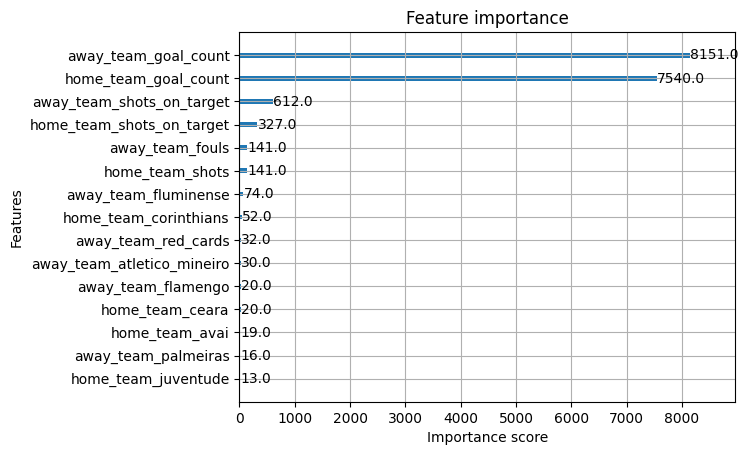

In [28]:
X_train, X_test, y_train, y_test = train_test_split(
    features, 
    labels, 
    train_size=0.8,  # 0.285 * 0.7 ≈ 20% of original
    random_state=42
)

# Define parameter grid (without early_stopping_rounds)
param_grid = {
    'max_depth': [2, 3],            # Reduced from 4
    'learning_rate': [0.001, 0.005],# 10x smaller than current
    'n_estimators': [2000, 3000],   # Compensate for lower LR
    'subsample': [0.5, 0.6],        # More aggressive
    'colsample_bytree': [0.6, 0.7],
    'reg_alpha': [10, 100],         # Stronger L1
    'reg_lambda': [50, 100],        # Stronger L2 
    'gamma': [1, 2]                 # Enforce simpler splits
}

best_score = np.inf
best_params = {}

# Manual grid search with proper early stopping
for max_depth in param_grid['max_depth']:
    for lr in param_grid['learning_rate']:
        for n_est in param_grid['n_estimators']:
            for subsample in param_grid['subsample']:
                for colsample in param_grid['colsample_bytree']:
                    for reg_a in param_grid['reg_alpha']:
                        for reg_l in param_grid['reg_lambda']:
                            for gamma in param_grid['gamma']:
                                
                                model = xgb.XGBClassifier(
                                    max_depth=max_depth,
                                    learning_rate=lr,
                                    n_estimators=n_est,
                                    subsample=subsample,
                                    colsample_bytree=colsample,
                                    reg_alpha=reg_a,
                                    reg_lambda=reg_l,
                                    gamma=gamma,
                                    early_stopping_rounds=20,
                                    eval_metric='mlogloss',
                                    random_state=42
                                )
                                
                                # Fit with validation set
                                model.fit(
                                    X_train, y_train,
                                    eval_set=[(X_val, y_val)],
                                    verbose=False
                                )
                                
                                # Get best validation score
                                val_score = model.best_score
                                
                                # Update best parameters if improved
                                if val_score < best_score:
                                    best_score = val_score
                                    best_params = {
                                        'max_depth': max_depth,
                                        'learning_rate': lr,
                                        'n_estimators': model.best_iteration+1,
                                        'subsample': subsample,
                                        'colsample_bytree': colsample,
                                        'reg_alpha': reg_a,
                                        'reg_lambda': reg_l,
                                        'gamma': gamma
                                    }

print("Best Parameters:", best_params)
print(f"Best Validation Score: {best_score:.4f}")

# Train final model with best parameters
final_model = xgb.XGBClassifier(
    use_label_encoder=False,  # Add this
    **best_params,
    eval_metric='mlogloss'
)

final_model.fit(
    X_train, y_train,
    eval_set=[(X_test, y_test)],
    verbose=False
)

# Evaluate on test set
y_pred = final_model.predict(X_test)
print("\nTest Set Performance:")
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Feature Importance Visualization
import matplotlib.pyplot as plt
xgb.plot_importance(final_model, max_num_features=15)
plt.show()